# Recommendation system

### Loading Data

#### Importing Libraries

In [55]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
movie = pd.read_csv("~/Downloads/ml-latest-small/movies.csv")
rating = pd.read_csv("~/Downloads/ml-latest-small/ratings.csv")

In [3]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movie.shape , rating.shape

((9742, 3), (100836, 4))

In [6]:
movie['year'] = movie.title.str.extract("\((\d{4})\)", expand=True)
movie.year = pd.to_datetime(movie.year, format='%Y')
movie.year = movie.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movie.title = movie.title.str[:-7]

In [7]:
movie.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0


#### Recommendation system based on User-based and item-based collaborative filtering

In [8]:
n_users = rating.userId.unique().shape[0]    # no of users
n_items = rating.movieId.unique().shape[0]   # no of movies

In [9]:
data_matrix = np.zeros((n_users, n_items))

In [10]:
for line in rating.itertuples():
    try:
        data_matrix[line[1]-1, line[2]-1] = line[3]
    except:
        pass

In [11]:
data_matrix #contains user ratings for each movie in matrix form

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [12]:
data_matrix.shape

(610, 9724)

#### we calculate the cosine similarity using pairwise_distance function from sklearn

In [13]:
from sklearn.metrics.pairwise import pairwise_distances 
user_similarity = pairwise_distances(data_matrix, metric='cosine') #user similarity matrix is created 
item_similarity = pairwise_distances(data_matrix.T, metric='cosine') # item similarity matrix is ceated

In [14]:
user_similarity.shape  , item_similarity.shape

((610, 610), (9724, 9724))

##### predict function returns item-based and user-based recomendations

In [15]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [16]:
user_prediction = predict(data_matrix, user_similarity, type='user')

In [17]:
item_prediction = predict(data_matrix, item_similarity, type='item')

In [18]:
def user_pred(movieid): # returns the movie to be recomended
    val = user_prediction[movieid].max()
    np.where(np.array(user_prediction)==val)
    au = int(np.where(np.array(user_prediction)==val)[1][0])
    return list(movie['title'][movie['movieId']== au])

In [19]:
user_pred(516)

['Santa Clause, The']

In [20]:
def item_pred(movieid): 
    val1 = item_prediction[movieid].max()
    item_prediction[item_prediction == val1]
    ai = int((np.where((np.array(item_prediction == val1))))[1][0])
    return list(movie['title'][movie['movieId'] == ai])

In [21]:
item_pred(516)

["April Fool's Day"]

### Recommendation on genre based Clustering

###### initialy we create sparse matrix 

In [22]:
movie.sort_values(by='movieId', inplace=True) #we sort to avoid confusions further
movie.reset_index(inplace=True, drop=True)
rating.sort_values(by='movieId', inplace=True)
rating.reset_index(inplace=True, drop=True)

we use split here to seperate genres and covert Dataframe to list to find unique generes, Boolen indicate True if movie belongs to that genere else False

In [23]:
genres_unique = pd.DataFrame(movie.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
k=movie.genres.str.get_dummies().astype(bool) 

covereted boolen into 1 & 0 

In [24]:
k1=k.astype(int)  

In [25]:
k1.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


we joined movie with spare matrix

In [26]:
movie1 = movie.join(k1)

In [27]:
movie1.head()

,movieId,title,genres,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,Comedy|Romance,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,Comedy,1995.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
movie1 = movie1.drop(['title','genres','year','movieId'],axis =1)

In [29]:
movie1.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
from scipy.cluster.hierarchy import linkage, dendrogram,cut_tree
from sklearn.metrics import silhouette_score

In [31]:
link = linkage(movie1, method='ward',metric='euclidean')

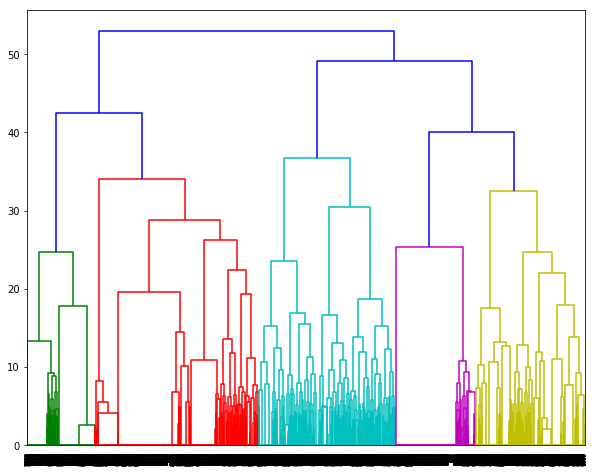

In [154]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
dend = dendrogram(link)

In [33]:
cluster = cut_tree(link,height=35).flatten()

In [34]:
silhouette_score(X=movie1,labels = cluster) #6clusters

0.14862739676548897

In [35]:
movie1.groupby(cluster).mean()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.000000,0.335826,0.631264,0.388930,0.422588,0.410621,0.047868,0.005984,0.247569,0.261032,0.000000,0.026926,0.043381,0.060583,0.025430,0.122663,0.038145,0.100972,0.011219,0.005236
1,0.000000,0.005858,0.000000,0.001674,0.000000,0.584100,0.061088,0.000000,0.618410,0.010042,0.005858,0.017573,0.000837,0.000837,0.044351,0.999163,0.025941,0.071130,0.001674,0.000000
2,0.000000,0.102304,0.027933,0.000698,0.019902,0.735684,0.103701,0.145601,0.282123,0.115922,0.000000,0.025140,0.006285,0.086243,0.016061,0.062849,0.006983,0.045042,0.002095,0.052025
3,0.017895,0.155263,0.011579,0.007368,0.004737,0.100526,0.388947,0.002105,0.447368,0.004737,0.041053,0.346316,0.004211,0.001053,0.211579,0.001579,0.062105,0.623684,0.000526,0.001053
4,0.000000,0.643954,0.256238,0.068138,0.031670,0.150672,0.017274,0.000000,0.290787,0.072937,0.001919,0.182342,0.068138,0.000960,0.035509,0.012476,0.724568,0.309981,0.006718,0.000960
5,0.000000,0.080484,0.035613,0.001425,0.000000,0.038462,0.005698,0.007835,0.947293,0.000712,0.000000,0.000712,0.001425,0.001425,0.000712,0.029915,0.003561,0.026353,0.250000,0.005698


In [36]:
geners_clust = movie1.groupby(cluster).mean().T

In [37]:
geners_clust

,0,1,2,3,4,5
(no genres listed),0.000000,0.000000,0.000000,0.017895,0.000000,0.000000
Action,0.335826,0.005858,0.102304,0.155263,0.643954,0.080484
Adventure,0.631264,0.000000,0.027933,0.011579,0.256238,0.035613
Animation,0.388930,0.001674,0.000698,0.007368,0.068138,0.001425
Children,0.422588,0.000000,0.019902,0.004737,0.031670,0.000000
Comedy,0.410621,0.584100,0.735684,0.100526,0.150672,0.038462
Crime,0.047868,0.061088,0.103701,0.388947,0.017274,0.005698
Documentary,0.005984,0.000000,0.145601,0.002105,0.000000,0.007835
Drama,0.247569,0.618410,0.282123,0.447368,0.290787,0.947293
Fantasy,0.261032,0.010042,0.115922,0.004737,0.072937,0.000712


In [38]:
pd.DataFrame(cluster).shape

(9742, 1)

In [39]:
movie1['cluster'] = cluster

In [40]:
mean_rating = rating.groupby(['movieId'], as_index=False)['rating'].aggregate(np.mean)
mean_rating.shape

(9724, 2)

In [41]:
mean_rating.head()

,movieId,rating
0,1,3.920930
1,2,3.431818
2,3,3.259615
3,4,2.357143
4,5,3.071429


In [42]:
movie_news = movie.merge(mean_rating, left_on='movieId', right_on='movieId', how='inner')

In [43]:
movie_new=movie_news.drop('genres',axis=1)
movie_new.shape

(9724, 4)

In [44]:
movie_new.head()

,movieId,title,year,rating
0,1,Toy Story,1995.0,3.920930
1,2,Jumanji,1995.0,3.431818
2,3,Grumpier Old Men,1995.0,3.259615
3,4,Waiting to Exhale,1995.0,2.357143
4,5,Father of the Bride Part II,1995.0,3.071429


In [45]:
mov = movie_new.join(pd.DataFrame(cluster))

In [46]:
mov.columns = ['movieId', 'title', 'year','rating', 'cluster']

In [47]:
def set_year_group(year):
    if (year < 1900): return 0
    elif (1900 <= year <= 1975): return 1
    elif (1976 <= year <= 1995): return 2
    elif (1996 <= year <= 2003): return 3
    elif (2004 <= year <= 2009): return 4
    elif (2010 <= year): return 5
    else: return 0
mov['year_group'] = mov.apply(lambda x: set_year_group(x['year']), axis=1)

In [48]:
mov.head()

,movieId,title,year,rating,cluster,year_group
0,1,Toy Story,1995.0,3.920930,0,2
1,2,Jumanji,1995.0,3.431818,0,2
2,3,Grumpier Old Men,1995.0,3.259615,1,2
3,4,Waiting to Exhale,1995.0,2.357143,1,2
4,5,Father of the Bride Part II,1995.0,3.071429,2,2


In [49]:
mov.to_csv("data",index=False)

In [165]:
def rec_frm_clust(movieId):
    data = pd.read_csv('data')
    a=list(data['cluster'][data['movieId']== movieId])[0]
    clust= data['cluster']==a
    rat = data['rating'] >=4.5
    y=list(data['year_group'][data['movieId']== 515])[0]
    yr_grp = data['year_group'] == y
    data.where(clust & rat ,inplace = True)
    d= data.dropna()
    d.where(yr_grp, inplace=True)
    s=d.dropna()
    data = s.sort_values(by='rating',ascending=False)
    rec_movies = list(s['title'].head())
    return rec_movies

In [166]:
rec_frm_clust(720)

['Lamerica',
 'La Cérémonie',
 'Red Sorghum (Hong gao liang)',
 'Cruel Romance, A (Zhestokij Romans)',
 'Last Hurrah for Chivalry (Hao xia)']

### Associative Rule  Mining

In [58]:
movie.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0


In [61]:
data1 = rating.drop('timestamp', axis =1)

In [63]:
movie_matrix = data1.pivot_table(index='userId',columns='movieId', values='rating')

In [64]:
def encode_units(x):
    if x >0:
        return 1
    else:
        return 0

In [65]:
basket_sets = movie_matrix.applymap(encode_units)

In [66]:
basket_sets.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
basket_sets.shape

(610, 9724)

In [68]:
basket_sets.columns

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            193565, 193567, 193571, 193573, 193579, 193581, 193583, 193585,
            193587, 193609],
           dtype='int64', name='movieId', length=9724)

In [69]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [70]:
frequent_itemsets = apriori(basket_sets, min_support=0.2, use_colnames=True)

In [71]:
frequent_itemsets.head()

,support,itemsets
0,0.352459,(1)
1,0.216393,(10)
2,0.290164,(32)
3,0.209836,(34)
4,0.332787,(47)


In [72]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=2)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(457),(150),0.311475,0.329508,0.208197,0.668421,2.028542,0.105563,2.022118
1,(150),(457),0.329508,0.311475,0.208197,0.631841,2.028542,0.105563,1.870182
2,(1196),(260),0.345902,0.411475,0.311475,0.900474,2.188403,0.169145,5.913271
3,(260),(1196),0.411475,0.345902,0.311475,0.756972,2.188403,0.169145,2.691454
4,(1210),(260),0.321311,0.411475,0.286885,0.892857,2.169892,0.154673,5.492896


In [167]:
rules[ (rules['lift'] >= 1) &
       (rules['confidence'] >= 0.40) ].head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(457),(150),0.311475,0.329508,0.208197,0.668421,2.028542,0.105563,2.022118
1,(150),(457),0.329508,0.311475,0.208197,0.631841,2.028542,0.105563,1.870182
2,(1196),(260),0.345902,0.411475,0.311475,0.900474,2.188403,0.169145,5.913271
3,(260),(1196),0.411475,0.345902,0.311475,0.756972,2.188403,0.169145,2.691454
4,(1210),(260),0.321311,0.411475,0.286885,0.892857,2.169892,0.154673,5.492896


In [152]:
def arm_rec(a):
    k = [a]
    l = []
    x=[]
    for i in range(len(rules.antecedents)):
        if list(rules.antecedents[i])==k:
            l.append(list(rules.consequents[i]))
            c = np.array(l).tolist() 
    for i in range (len(c)):
        res = print(list(movie['title'][movie['movieId']== c[i][0]]))
    return res

In [153]:
arm_rec(457)

['Apollo 13']
['True Lies']
['Batman']
['Jurassic Park']


In [168]:
rating['userId'][rating['movieId']== 457]

12607    597
12608    592
12609    116
12610    594
12611    328
12612    266
12613    596
12614    254
12615      8
12616    126
12617    340
12618    565
12619    480
12620    584
12621    573
12622    477
12623     86
12624    353
12625    590
12626    572
12627    339
12628    577
12629    102
12630      4
12631    109
12632     84
12633    476
12634    588
12635    330
12636    607
        ... 
12767    602
12768     19
12769    317
12770    179
12771    178
12772    536
12773    488
12774    372
12775    156
12776    486
12777    610
12778    133
12779    528
12780     45
12781    219
12782    474
12783     43
12784      6
12785    385
12786    290
12787    599
12788     42
12789    507
12790    402
12791    404
12792    323
12793    292
12794    465
12795     79
12796    510
Name: userId, Length: 190, dtype: int64